In [1]:
import pickle as pkl
import numpy as np
import pandas as pd
import requests as rq
import json
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from networkx.drawing.nx_agraph import graphviz_layout
import matplotlib.cm as cm
from empath import Empath
import math

In [2]:
RedditData = "../Data/reddit_suicideWatch/suicidewatch.pickl"

In [3]:
data = pd.read_pickle(open(RedditData,'rb'))

In [4]:
data.head()

,approved_by,archived,author,author_flair_css_class,author_flair_text,banned_by,body,body_html,controversiality,created,...,pronouns,pronounsNo,sentencesNo,definiteArticlesNo,firstPersonPronouns,firstPersonPronounsNo,LL,afinn,labmt,firstPersonPronounsRatio
0,NaN,True,freakball,None,None,NaN,"Thats it, I'm starting the church of mr rogers.",NaN,0.0,NaN,...,"{u'I': 1, u'it': 1}",2.0,1,1.0,{u'I': 1},1.0,-10.621782,0.000000,0.124441,0.500000
1,NaN,True,[deleted],None,None,NaN,[deleted],NaN,0.0,NaN,...,{},0.0,1,0.0,{},0.0,NaN,NaN,NaN,NaN
2,NaN,True,[deleted],None,None,NaN,[deleted],NaN,0.0,NaN,...,{},0.0,1,0.0,{},0.0,NaN,NaN,NaN,NaN
3,NaN,True,[deleted],None,None,NaN,A really gorgeous album that came out in 2007 ...,NaN,0.0,NaN,...,"{u'I': 5, u'you': 4, u'It': 3, u'yourself/your...",18.0,11,6.0,{u'I': 5},5.0,-10.323336,1.639824,0.854738,0.277778
4,NaN,True,sub_o,None,None,NaN,"what you wish, is their happiness. you don't w...",NaN,0.0,NaN,...,"{u'we': 4, u'your': 2, u'them': 8, u'it': 3, u...",49.0,26,7.0,"{u'our': 1, u'we': 4}",5.0,-9.130422,2.092457,2.318952,0.102041


In [5]:
filteredData = data[((data['author'] != '[deleted]') & (pd.notnull(data['permalink']))  & (data['num_comments'] > 0 ) ) ]

In [6]:
len(filteredData)

50754

In [7]:
# pd.to_pickle(filteredData , "../Data/reddit_suicideWatch/filteredSuicideWatch_All_valid.pkl")

In [8]:
filteredData.iloc[12]['id']

u'failv'

In [9]:
# thread[0]

In [10]:
def sanitizeText(text):
    return text.encode('utf8').replace('\n', '').replace('\r', '')
    
def getAffects(text):
    lexicon = Empath()
    affects = lexicon.analyze(text , normalize=False)
    return affects


In [11]:

def getSubThread(url):
    session_headers = {
    'Host': 'www.reddit.com',
    'Connection': 'keep-alive',
    'Cache-Control': 'max-age=0',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    #'Referer': 'http://localhost:9000/notebooks/Reddit/Notebooks/SuicideWatchSubreddit.ipynb'
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-GB,en-US;q=0.8,en;q=0.6',
    'Cookie': "loid=00000000000gslzvdi.2.1507591930964.Z0FBQUFBQlozQWI3M243MTdFMUgzNWtQNzNVbzg5Z3NXYmxpLUdRTWVXdEpWQzBfbkxBSVNNVVF3dE1zQlN5cVMzeGtxZXlmT0JQY2JvTld2NWlVeGlGeFpkNnBYM2ZIYlNNR2xMWGFFS3hieDZpWEJ5OVlyTng0MUFZZjNYdjQ0ZURFNTFlSmlVRGw; edgebucket=T8nkTF0z7WPnNzlE8B; __gads=ID=ab9c1b0fcb7eaefc:T=1507591936:S=ALNI_Mao2tvEoyJzEDEuxxhfZBlOQHXlsA; eu_cookie_v2=3; _ga=GA1.2.1088810883.1507591931; __utma=55650728.1088810883.1507591931.1507912304.1507912553.14; __utmz=55650728.1507912553.14.11.utmcsr=reddit|utmccn=(not%20set)|utmcmd=hot|utmcct=comments; aa=1; _recentclicks2=t3_7cfzsx%2Ct3_7cfw08%2Ct3_7cdofu%2Ct3_7caog1%2Ct3_7cdvud; _recent_srs=t5_2qpzs%2Ct5_2qh1q%2Ct5_2qh49%2Ct5_2rtff%2Ct5_36buk%2Ct5_2r7yd%2Ct5_2rks3%2Ct5_3j2jr%2Ct5_2sumw%2Ct5_2xp2o; pc=r3; session_tracker=tPgx9U9yPt99jYRDqC.0.1510585492994.Z0FBQUFBQmFDYlNWcWZHclI5WWxDWW9kQ0dURk9FRU9BZjFJTURWZElzaldRbkROaEJUOWE1czRQUWxPUzUwOFFwY3R3ckI5VkNDUlhJc01NVEtEeHVWd25CdUpXWEI1X012RkJaS3cyNXdNbk5vOE9DSXp5ZlhuTzF3a2pxT2dLZ3laMDhtQlhib3k; initref=localhost"
    }

    client = rq.session()
    resp = client.get(url , headers=session_headers)
    if resp.status_code == 200:
        json_data = json.loads(resp.text)
        return json_data

    else:
        print "Failed to get the thread"
        return None

In [22]:
def getScaledSizes(graph):
    affects = nx.get_node_attributes(graph, 'affects')
    print affects
    s = [int(affects[v]) for v in graph.nodes()]
    normed = [i + 10 for i in s]
    scaled = [v*(2^(v-np.min(normed)))+100 for v in normed]
    return scaled

In [23]:
# def parseChildren(jsonDict , graph):
#     if jsonDict['kind'] == 'more':
#         print "Needs deeper probing !!"
#         return
#     data = jsonDict['data']
#     affects = getAffects(sanitizeText(data['body']))
# #     print data['name']
#     propertyDict = {'author' : data['author'] , 'ups' : data['ups'] , 'downs' : data['downs'] , 'text' : sanitizeText(data['body']) , 'depth' : data['depth'] , 'affects' : sum(affects.values()) }
#     graph.add_node(data['name'] , propertyDict )
#     graph.add_edge(data['name'], data['parent_id'] , weight=1 )
#     if data['replies'] != '':
#         if len(data['replies']['data']['children']) > 0:
#             for k in data['replies']['data']['children']:
#                 parseChildren(k, graph)
#     else:
#         return
    
def parseChildren(jsonDict , graph , permUrl , motherDepthOffset):
    if jsonDict['kind'] == 'more':
        print "Need Deeper Probing !!!!!! "
        deepterThreadId = jsonDict['data']['parent_id'].split('_')[1]
        offsetDepth = motherDepthOffset + jsonDict['data']['depth']+1
        print deepterThreadId
        getUrl = permUrl+deepterThreadId+"/.json"
        print "Getting Nested Thread from : " + getUrl
        deeperDict = getSubThread(getUrl)
        if deeperDict != None:
            graph = parseRedditJsonConvTree(deeperDict,graph,offsetDepth)
            return
        else:
            print "Silently Returning"
            return
        
    data = jsonDict['data']
    affects = getAffects(sanitizeText(data['body']))
    # print data['name']
    propertyDict = {'author' : data['author'] , 'ups' : data['ups'] , 'downs' : data['downs'] , 'text' : sanitizeText(data['body']) , 'depth' : (motherDepthOffset + data['depth'])-1 , 'affects' : sum(affects.values()) }
    graph.add_node(data['name'] , propertyDict )
    graph.add_edge(data['name'], data['parent_id'] , weight=1 )
    if data['replies'] != '':
        if len(data['replies']['data']['children']) > 0:
            for k in data['replies']['data']['children']:
                parseChildren(k, graph , permUrl , motherDepthOffset )
    else:
        return
    
def parseRedditJsonConvTree(jsonDict,motherGraph=None,DepthOffset=0):
    if motherGraph != None:
        replyGraph = motherGraph
        root = jsonDict[1]
        perma = root['data']['children'][0]['data']['permalink']
        url = "http://www.reddit.com"+perma

    else:
        root = jsonDict[0]
        perma = root['data']['children'][0]['data']['permalink']
        url = "http://www.reddit.com"+perma
        replyGraph = nx.DiGraph()
        data = root['data']['children'][0]['data']
        affects = getAffects(data['selftext'])
        propertyDict = {'author' : data['author'] , 'ups' : data['ups'] , 'downs' : data['downs'] , 'text' : sanitizeText(data['selftext']) , 'depth' : DepthOffset-1, 'affects' : sum(affects.values())}
        replyGraph.add_node(data['name'] , propertyDict )
    
    if len(jsonDict[1]['data']['children']) > 0:
        for k in jsonDict[1]['data']['children']:
            parseChildren(k , replyGraph , url , DepthOffset)
    return replyGraph
    
    

In [24]:
testperma = filteredData.iloc[2909]['permalink']

url = "http://www.reddit.com"+testperma+".json"
print url


session_headers = {
'Host': 'www.reddit.com',
'Connection': 'keep-alive',
'Cache-Control': 'max-age=0',
'Upgrade-Insecure-Requests': '1',
'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36',
'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
#'Referer': 'http://localhost:9000/notebooks/Reddit/Notebooks/SuicideWatchSubreddit.ipynb'
'Accept-Encoding': 'gzip, deflate, br',
'Accept-Language': 'en-GB,en-US;q=0.8,en;q=0.6',
'Cookie': "loid=00000000000gslzvdi.2.1507591930964.Z0FBQUFBQlozQWI3M243MTdFMUgzNWtQNzNVbzg5Z3NXYmxpLUdRTWVXdEpWQzBfbkxBSVNNVVF3dE1zQlN5cVMzeGtxZXlmT0JQY2JvTld2NWlVeGlGeFpkNnBYM2ZIYlNNR2xMWGFFS3hieDZpWEJ5OVlyTng0MUFZZjNYdjQ0ZURFNTFlSmlVRGw; edgebucket=T8nkTF0z7WPnNzlE8B; __gads=ID=ab9c1b0fcb7eaefc:T=1507591936:S=ALNI_Mao2tvEoyJzEDEuxxhfZBlOQHXlsA; eu_cookie_v2=3; _ga=GA1.2.1088810883.1507591931; __utma=55650728.1088810883.1507591931.1507912304.1507912553.14; __utmz=55650728.1507912553.14.11.utmcsr=reddit|utmccn=(not%20set)|utmcmd=hot|utmcct=comments; aa=1; _recentclicks2=t3_7cfzsx%2Ct3_7cfw08%2Ct3_7cdofu%2Ct3_7caog1%2Ct3_7cdvud; _recent_srs=t5_2qpzs%2Ct5_2qh1q%2Ct5_2qh49%2Ct5_2rtff%2Ct5_36buk%2Ct5_2r7yd%2Ct5_2rks3%2Ct5_3j2jr%2Ct5_2sumw%2Ct5_2xp2o; pc=r3; session_tracker=tPgx9U9yPt99jYRDqC.0.1510585492994.Z0FBQUFBQmFDYlNWcWZHclI5WWxDWW9kQ0dURk9FRU9BZjFJTURWZElzaldRbkROaEJUOWE1czRQUWxPUzUwOFFwY3R3ckI5VkNDUlhJc01NVEtEeHVWd25CdUpXWEI1X012RkJaS3cyNXdNbk5vOE9DSXp5ZlhuTzF3a2pxT2dLZ3laMDhtQlhib3k; initref=localhost"
}

client = rq.session()

resp = client.get(url , headers=session_headers)

resp.status_code

thread = json.loads(resp.content)

http://www.reddit.com/r/SuicideWatch/comments/gmgsc/my_wife_wants_to_end_it_all/.json


In [25]:
print type(thread[0]['data']['before'])

<type 'NoneType'>


In [26]:

cascadeGraph = parseRedditJsonConvTree(thread )

In [27]:
# affects = nx.get_node_attributes(cascadeGraph, 'affects')

# print affects

# sizes = [int(affects[v]) for v in cascadeGraph.nodes()]

# print sizes

# normedSizes = [i + 10 for i in sizes]
# scaledSizes = [v*(2^(v-np.min(normedSizes)))+100 for v in normedSizes]
# # scaledSizes = normedSizes

# print scaledSizes

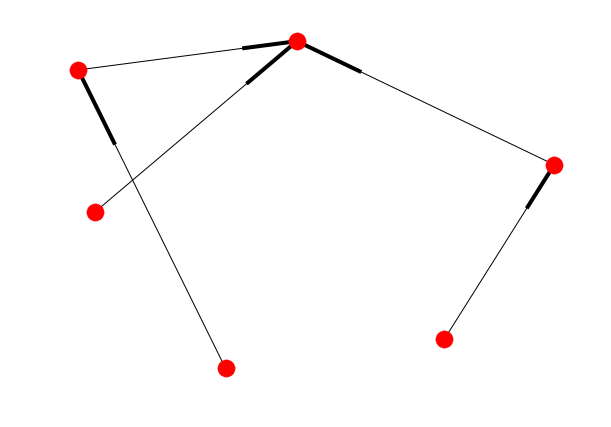

In [28]:
nx.draw(cascadeGraph)

{u't1_c1otdur': 0.0, u't1_c1ompne': 139.0, u't3_gmgsc': 188.0, u't1_c1p4pob': 30.0, u't1_c1xqlkk': 25.0, u't1_c1omzq6': 103.0}
[120, 20513, 37720, 1220, 1045, 11513]
4


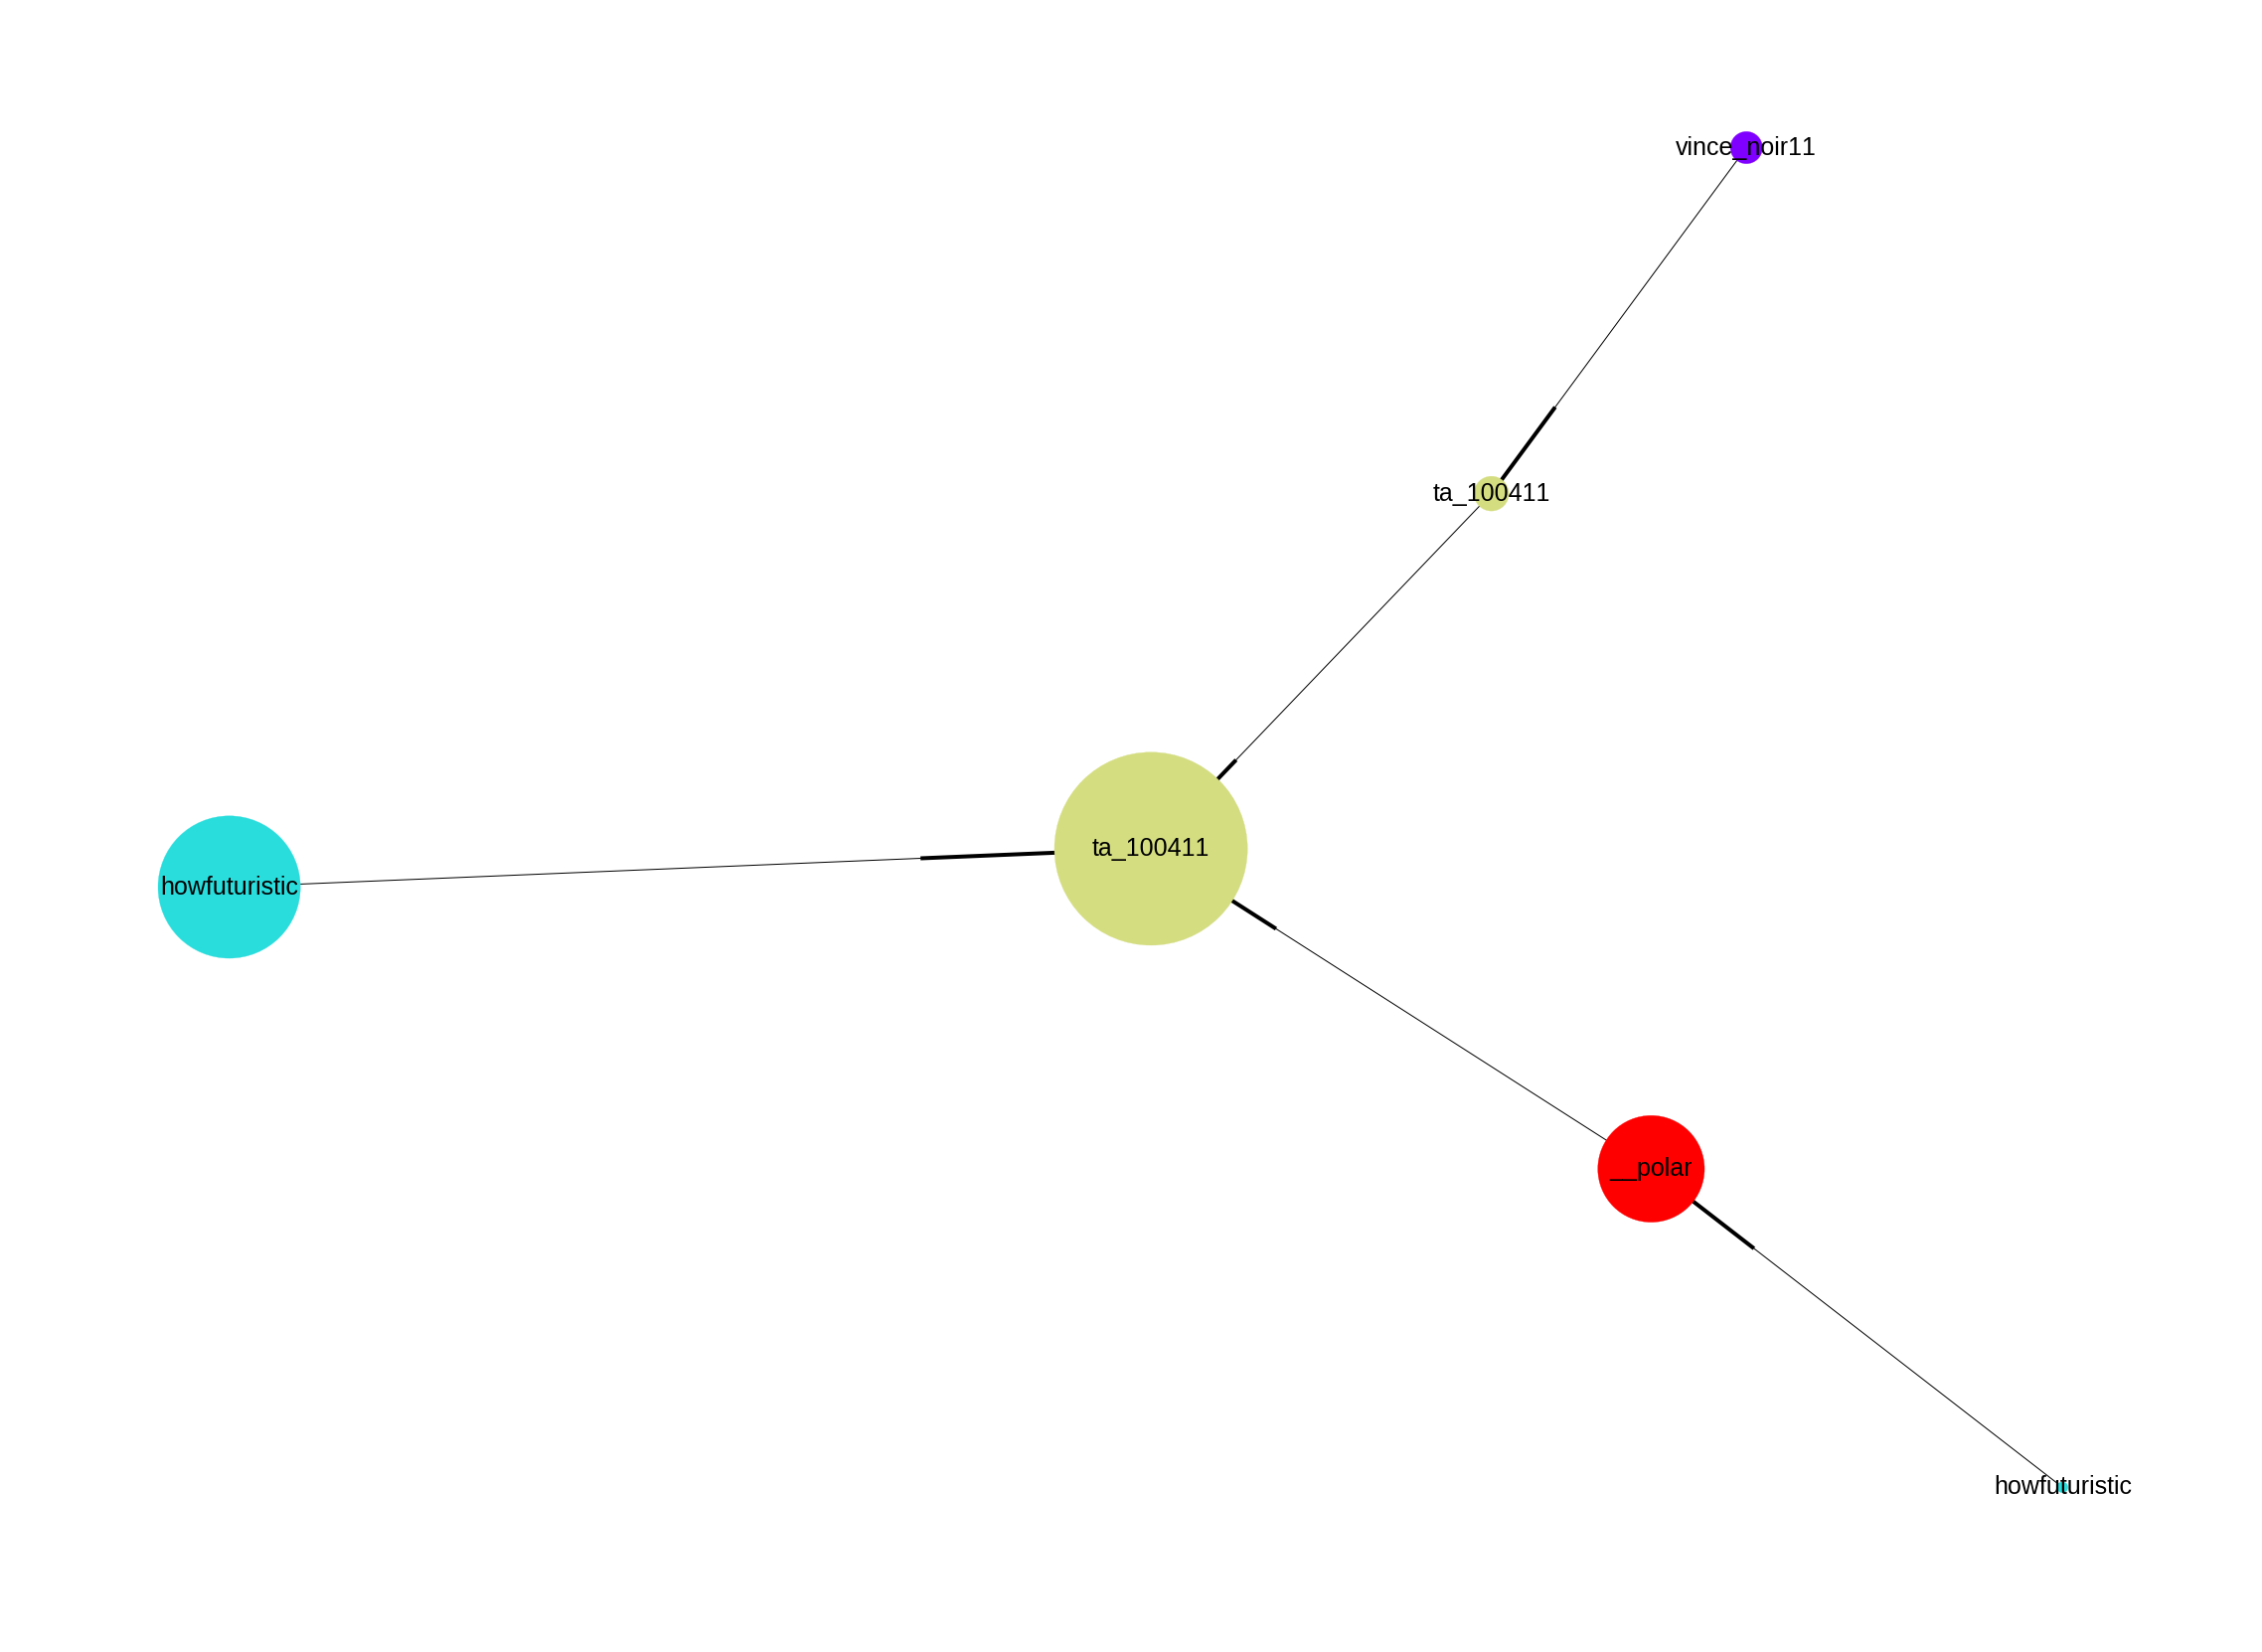

In [29]:

pos = graphviz_layout(cascadeGraph, prog='neato')
sizes = getScaledSizes(cascadeGraph)
print sizes
usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
print len(usr)
color=cm.rainbow(np.linspace(0,1,len(usr)))
colorMap = []
lls = {}
for node in cascadeGraph:
    c = usr.index(cascadeGraph.node[node]['author'])
    colorMap.append(color[c])
    lls[node] = cascadeGraph.node[node]['author']
fig, ax = plt.subplots()
fig.set_size_inches(40, 30)
#
nx.draw(cascadeGraph,pos=pos ,node_size=sizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
plt.show()

In [30]:
# print nx.get_node_attributes(cascadeGraph,'text')

In [53]:
# Allgraphs = "../Data/reddit_suicideWatch/SW_morethan10_graphs_complete_revised/SW_morethan10_deeper_replygraphs.pkl"
Allgraphs = "../Data/reddit_CMV/CMV_sub_FP_graph/CMV_TopPosts_replygraphs.pkl"

In [54]:
allGraphs = pkl.load(open(Allgraphs,'rb'))

In [60]:
len(allGraphs)

713

In [56]:
textDict = {}
for k in allGraphs:
    postText = nx.get_node_attributes(allGraphs[k],'text')
    textDict.update(postText)

In [57]:
len(textDict)

51476

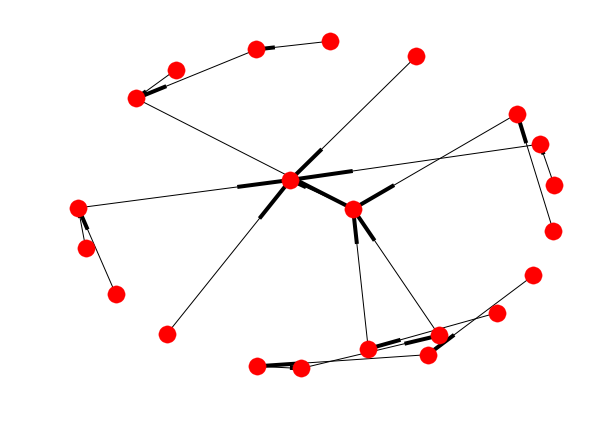

In [58]:
nx.draw(allGraphs[allGraphs.keys()[15]])

In [59]:
# import csv
# fieldnames = ['postid', 'text']
# with open('../Data/reddit_CMV/reddit_CMF_FP_text.csv', 'wb') as output_file:
#     dict_writer = csv.DictWriter(output_file, fieldnames=fieldnames)
#     dict_writer.writeheader()
#     for k in textDict:
#         dict_writer.writerow({'postid': k , 'text': textDict[k]})


In [62]:
# LIWC = pd.read_csv("/datasets_1/sagarj/IoPPN_collab/reddit_suicideWatch/LIWC2015_SWTextDeeper.csv")
LIWC= pd.read_csv("/datasets_1/sagarj/IoPPN_collab/reddit_CMV/LIWC2015_reddit_CMF_FP_text.csv")

In [63]:
len(LIWC)

51477

In [64]:
LIWC.drop(LIWC.index[0])

,A,B,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
1,t1_dpt4yhv,"Certainly, you could use a different font. Hel...",147,63.57,58.08,7.24,85.33,13.36,19.73,80.95,...,6.12,0.68,0.00,0.00,0.0,0.00,0.00,0.68,1.36,0.00
2,t1_dq41jz5,"Take a look in your mouth, notice the presence...",59,99.00,75.12,45.61,25.77,29.50,25.42,88.14,...,6.78,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
3,t1_dq5nvxb,Like slavery you mean?,4,92.84,99.00,74.76,25.77,4.00,25.00,100.00,...,0.00,0.00,0.00,25.00,0.0,0.00,0.00,0.00,0.00,0.00
4,t1_dqocdet,[removed],1,92.84,50.00,99.00,25.77,1.00,100.00,100.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,200.00
5,t1_dqfjtvz,"It’s unethical to do any trophy hunting, but n...",119,53.35,50.00,1.83,40.93,29.75,22.69,80.67,...,9.24,0.00,0.00,0.84,0.0,0.00,0.00,1.68,0.00,0.00
6,t1_dqkpkq5,"Oh Sorry, you are not the top commentator in t...",97,61.27,76.47,22.64,25.77,24.25,14.43,90.72,...,5.15,0.00,2.06,2.06,0.0,1.03,2.06,1.03,0.00,2.06
7,t1_dqu6glu,You cannot operate in a society without trust ...,33,56.58,50.00,51.41,25.77,6.60,33.33,78.79,...,0.00,0.00,0.00,0.00,0.0,3.03,0.00,0.00,0.00,0.00
8,t1_dpytaw2,"but if laws don't apply to all cases, that mea...",14,1.00,1.00,89.63,25.77,14.00,7.14,85.71,...,7.14,0.00,0.00,0.00,0.0,0.00,0.00,14.29,0.00,0.00
9,t1_dpqd5e4,They are totally alarmist and nothing to worry...,167,23.66,83.10,1.00,3.26,15.18,19.76,91.02,...,0.00,0.00,0.00,0.00,0.0,0.00,0.00,4.19,3.59,0.00
10,t1_dq0gwmx,"Another finger on your right hand, or on your ...",10,51.43,99.00,99.00,25.77,10.00,10.00,100.00,...,10.00,0.00,0.00,10.00,0.0,0.00,0.00,0.00,0.00,0.00


In [65]:
LIWC.head()

,A,B,WC,Analytic,Clout,Authentic,Tone,WPS,Sixltr,Dic,...,Comma,Colon,SemiC,QMark,Exclam,Dash,Quote,Apostro,Parenth,OtherP
0,postid,text,1,92.84,50.00,1.00,25.77,1.00,0.00,0.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,t1_dpt4yhv,"Certainly, you could use a different font. Hel...",147,63.57,58.08,7.24,85.33,13.36,19.73,80.95,...,6.12,0.68,0.0,0.0,0.0,0.0,0.0,0.68,1.36,0.0
2,t1_dq41jz5,"Take a look in your mouth, notice the presence...",59,99.00,75.12,45.61,25.77,29.50,25.42,88.14,...,6.78,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
3,t1_dq5nvxb,Like slavery you mean?,4,92.84,99.00,74.76,25.77,4.00,25.00,100.00,...,0.00,0.00,0.0,25.0,0.0,0.0,0.0,0.00,0.00,0.0
4,t1_dqocdet,[removed],1,92.84,50.00,99.00,25.77,1.00,100.00,100.00,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,200.0


In [66]:
affectDict = {}
for index , row in LIWC.iterrows():
    affectDict[row['A']] =row['posemo'] - row['negemo'] 
    

In [67]:
len(affectDict)

51477

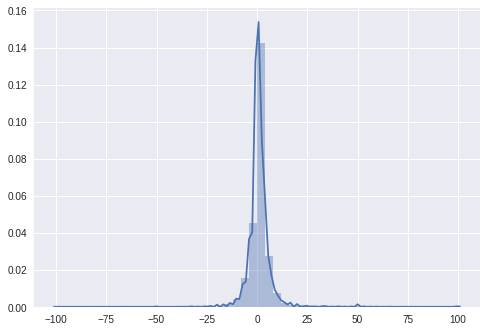

In [68]:
sns.distplot(affectDict.values())

In [69]:
for g in allGraphs:
    
    updateDict = {}
    for n in allGraphs[g].nodes():
        if n not in affectDict:
            continue
        updateDict[n] = affectDict[n]
    nx.set_node_attributes(allGraphs[g] , 'affects' , updateDict)

In [70]:
testGraph = allGraphs[allGraphs.keys()[10]]

In [71]:
nodes =nx.get_node_attributes(testGraph,'author')
edges = testGraph.edges()

In [119]:
# cascadeGraph = allGraphs[allGraphs.keys()[51]]
# sizes = getScaledSizes(cascadeGraph)
# print sizes
# pos = graphviz_layout(cascadeGraph, prog='neato')

# usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
# print len(usr)
# color=cm.rainbow(np.linspace(0,1,len(usr)))
# colorMap = []
# lls = {}
# for node in cascadeGraph:
#     c = usr.index(cascadeGraph.node[node]['author'])
#     colorMap.append(color[c])
#     lls[node] = cascadeGraph.node[node]['author']
# fig, ax = plt.subplots()
# fig.set_size_inches(40, 30)
# #
# nx.draw(cascadeGraph,pos=pos ,node_size=sizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
# plt.show()

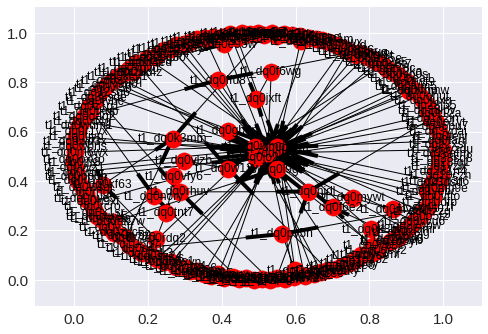

In [120]:
nx.draw_networkx(cascadeGraph)

In [78]:
# nx.get_node_attributes(allGraphs[allGraphs.keys()[10]], 'ups')

In [80]:
nx.get_node_attributes(allGraphs[allGraphs.keys()[1]], 'author').values().count('[deleted]')

2

In [81]:
userDist = [len(list(set(nx.get_node_attributes(allGraphs[g], 'author').values()))) for g in allGraphs]

In [82]:
depthDist = [max(list(set(nx.get_node_attributes(allGraphs[g], 'depth').values()))) for g in allGraphs]

In [83]:
upsDist = [max(list(set(nx.get_node_attributes(allGraphs[g], 'ups').values()))) for g in allGraphs]

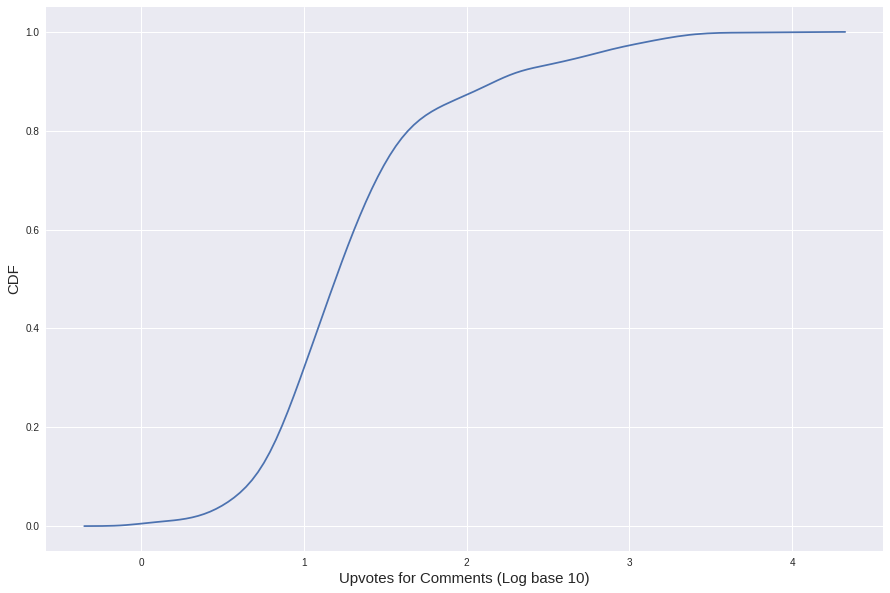

In [84]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(np.log10(upsDist),hist = False,kde_kws=dict(cumulative=True))
sns.set(font_scale=1.5) 
plt.xlabel("Upvotes for Comments (Log base 10)", fontsize = 15)
plt.ylabel("CDF", fontsize = 15)

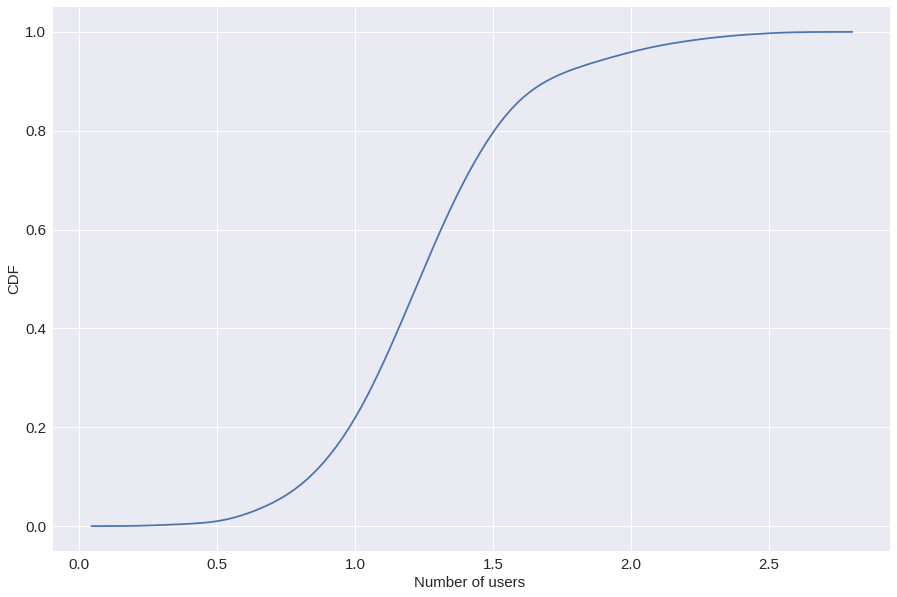

In [85]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(np.log10(userDist),hist = False,kde_kws=dict(cumulative=True))
sns.set(font_scale=1.5) 
plt.xlabel("Number of users ", fontsize = 15)
plt.ylabel("CDF", fontsize = 15)

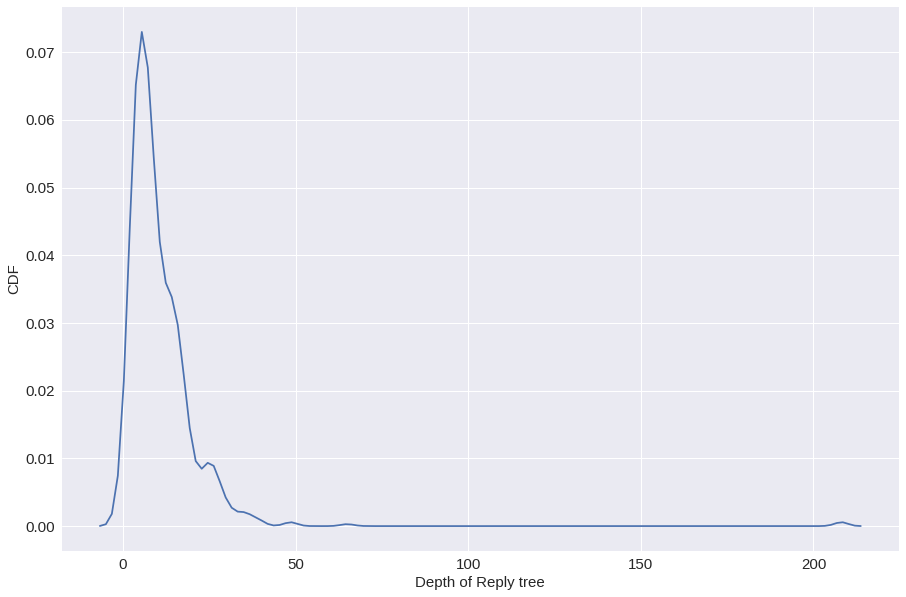

In [86]:
fig, ax = plt.subplots(figsize=(15,10))
sns.distplot(depthDist , hist=False , kde_kws=dict(cumulative=False))
sns.set(font_scale=1.5) 
plt.xlabel("Depth of Reply tree", fontsize = 15)
plt.ylabel("CDF", fontsize = 15)

In [87]:
userGraphs = {}
for i in allGraphs:
    deletedusers = nx.get_node_attributes(allGraphs[i], 'author').values().count('[deleted]')
    if deletedusers > 3:
        continue
    userGraph = nx.DiGraph()
    nodes = nx.get_node_attributes(allGraphs[i],'author')
    for e in allGraphs[i].edges():
        if e[0] not in nodes and e[1] not in nodes:
            continue
        elif e[0] not in nodes:
            src = "deleted"
            dst = nodes[e[1]]
        elif e[1] not in nodes:
            src = nodes[e[0]]
            dst = "deleted"
        else:
            src = nodes[e[0]]
            dst = nodes[e[1]]
        if not userGraph.has_node(src):
            userGraph.add_node(src)
        if not userGraph.has_node(dst):
            userGraph.add_node(dst)  
        if not userGraph.has_edge(src,dst):
            userGraph.add_edge(src, dst , weight=1 )
        else:
            userGraph[src][dst]['weight'] += 1
    userGraphs[i] = userGraph

In [88]:
len(userGraphs)

584

In [89]:
key = userGraphs.keys()[12]

# cascadeGraph = allGraphs[key]
# sizes = getScaledSizes(cascadeGraph)
# print sizes
# pos = graphviz_layout(cascadeGraph, prog='neato')

# usr = list(set(nx.get_node_attributes(cascadeGraph, 'author').values()))
# print len(usr)
# color=cm.rainbow(np.linspace(0,1,len(usr)))
# colorMap = []
# lls = {}
# for node in cascadeGraph:
#     c = usr.index(cascadeGraph.node[node]['author'])
#     colorMap.append(color[c])
#     lls[node] = cascadeGraph.node[node]['author']
# fig, ax = plt.subplots()
# fig.set_size_inches(40, 30)
# #
# nx.draw(cascadeGraph,pos=pos ,node_size=scaledSizes ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
# plt.show()

39


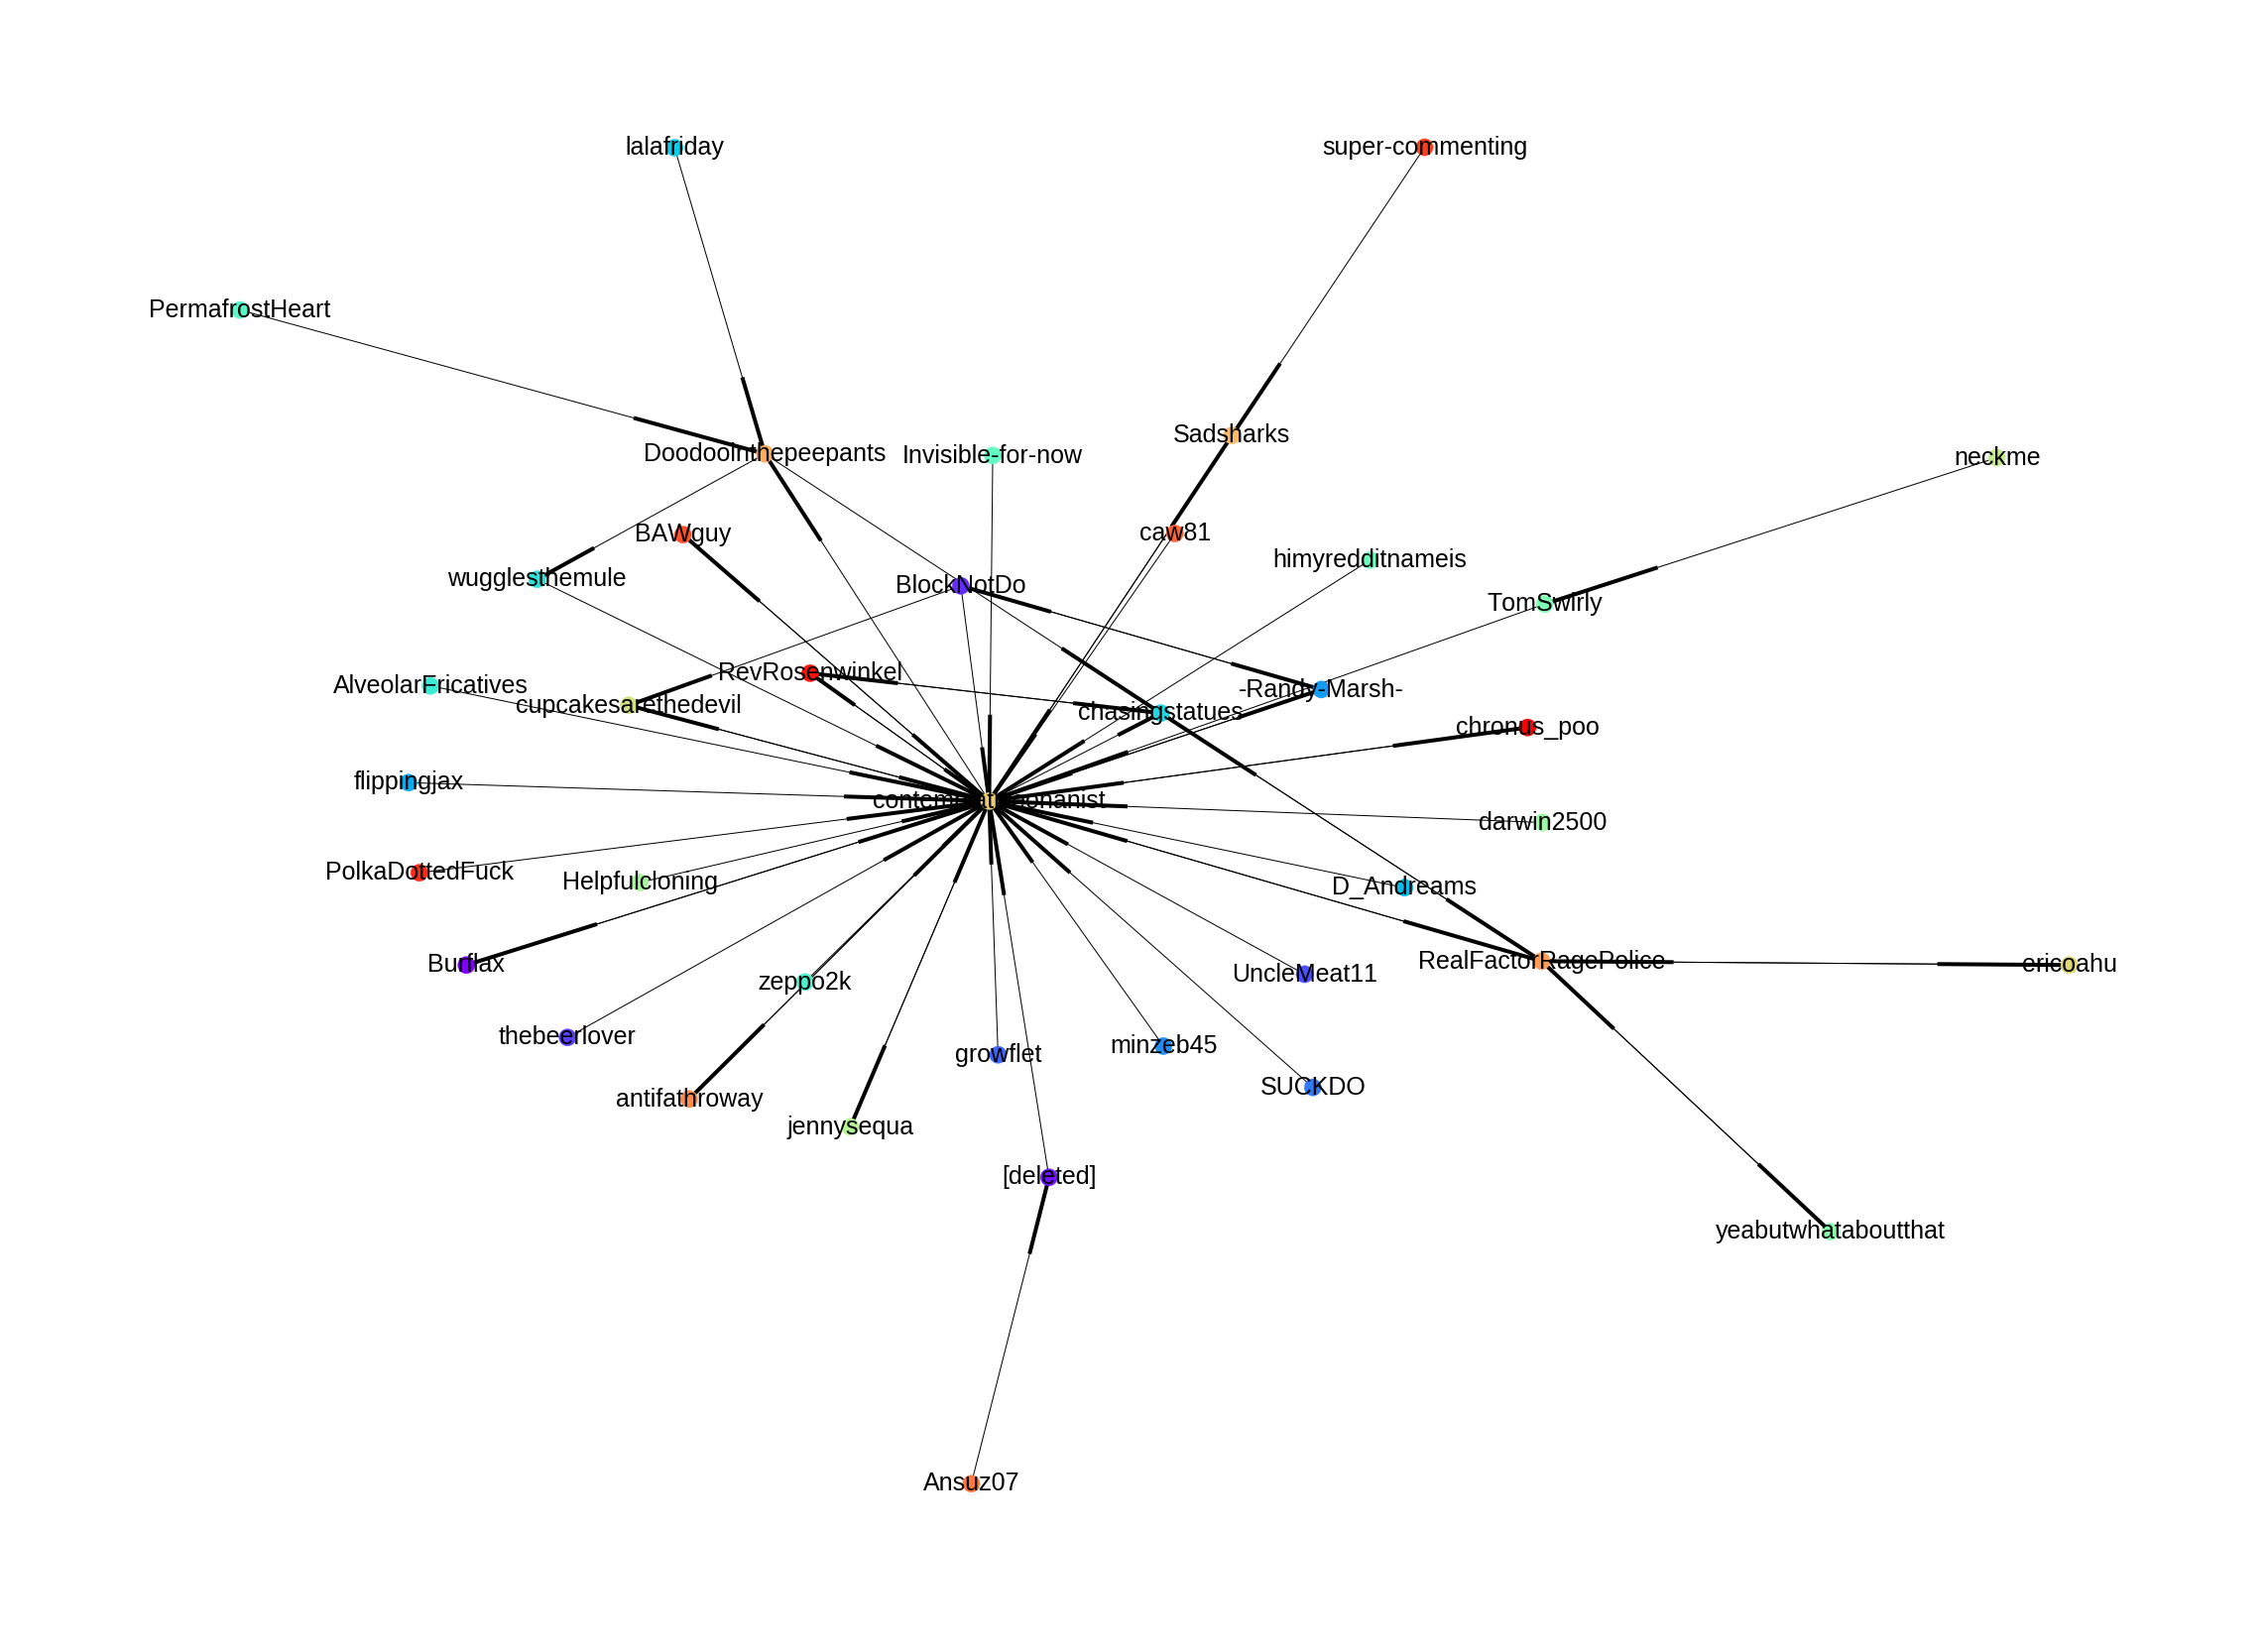

In [118]:
key = userGraphs.keys()[75]
ugraph = userGraphs[key]
# sizes = getScaledSizes(cascadeGraph)
pos = graphviz_layout(ugraph, prog='neato')

usr = ugraph.nodes()
print len(usr)
color=cm.rainbow(np.linspace(0,1,len(usr)))
colorMap = []
lls = {}
for node in ugraph:
    c = usr.index(node)
    colorMap.append(color[c])
    lls[node] = node
fig, ax = plt.subplots()
fig.set_size_inches(40, 30)
#
nx.draw(ugraph,pos=pos ,node_color=colorMap , with_labels = True , labels = lls , font_size=25)
plt.show()

In [92]:
nx.triangles(userGraphs[key].to_undirected()).values()

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]

In [93]:
rootAffects = []
for k in allGraphs:
    g = allGraphs[k]
    for n in g.node:
        if 'depth' in g.node[n] and g.node[n]['depth'] == -1:
            rootAffects.append(g.node[n]['affects'])

In [94]:
# from collections import Counter
# Counter(rootAffects)

In [95]:
depths = []
sentiments = []
rootAuthors = []


sentiChanges = []
sentiDeltas = [] 
participants = []
conversations = []
medianRootSentiments = []
maxRootSentiments = []
maxSentimentDepth = []
triangles = []
maxDepths = []
Zscore = []
rootEngagement = []
for k in allGraphs:
    if k in userGraphs:
        rootSentiments = []
        rootDepth = []
        g = allGraphs[k]
        rootAuthor = None
        posChange = 0
        negChange = 0
        rootSenti = 0
        for node in g:
            if 'depth' in g.node[node]:
                if g.node[node]['depth'] == -1:
                    rootSenti = g.node[node]['affects']
                    rootAuthor = g.node[node]['author']
                    rootAuthors.append(rootAuthor)
                    rootSentiments.append(rootSenti)
                    rootDepth.append(-1)
        if rootSenti == 0:
            continue
            
            
        conversations.append(len(g.nodes()))
        participants.append(len(userGraphs[k].nodes()))
        threadSentiment = [rootSenti]
        if rootAuthor == None:
            continue
        else:
            for node in g:
                if 'depth' in g.node[node]:
                    if g.node[node]['author'] == rootAuthor:
                        depths.append(g.node[node]['depth'])
                        rootDepth.append(g.node[node]['depth'])
                        sentiments.append(g.node[node]['affects'])
                        sentiChanges.append(g.node[node]['affects'] - rootSenti)
                        rootSentiments.append(g.node[node]['affects'])
                        if (g.node[node]['affects'] - rootSenti) > 0:
                            posChange+=1
                        else:
                            negChange+=1
                        threadSentiment.append(g.node[node]['affects'])
                    
            maxDepths.append( max(nx.get_node_attributes(allGraphs[k], 'depth').values()) )
#             print np.argmax(rootSentiments)
            maxSentimentDepth.append(rootDepth[np.argmax(rootSentiments)])
            score = (float(posChange) - float(negChange))/math.sqrt(float(posChange) + float(negChange))
            Zscore.append(score)
            medianRootSentiments.append(np.median(threadSentiment))
            maxRootSentiments.append(max(threadSentiment))
            rootEngagement.append(len(threadSentiment)-1)
            triangles.append(sum(list(nx.triangles(userGraphs[k].to_undirected()).values()))/3)
        
    
print len(rootAuthors)

6019


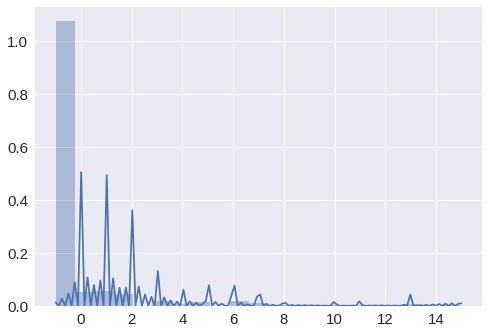

In [96]:
sns.distplot(maxSentimentDepth)

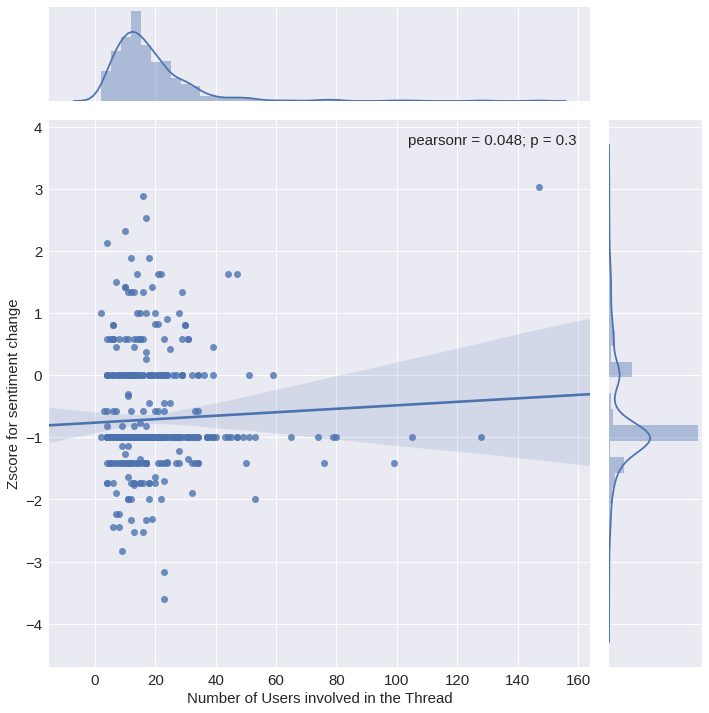

In [97]:
sns.jointplot(x = np.asarray(participants) , y = np.asarray(Zscore) , kind='reg' ,size = 10);
plt.xlabel("Number of Users involved in the Thread", fontsize = 15)
plt.ylabel("Zscore for sentiment change", fontsize = 15)

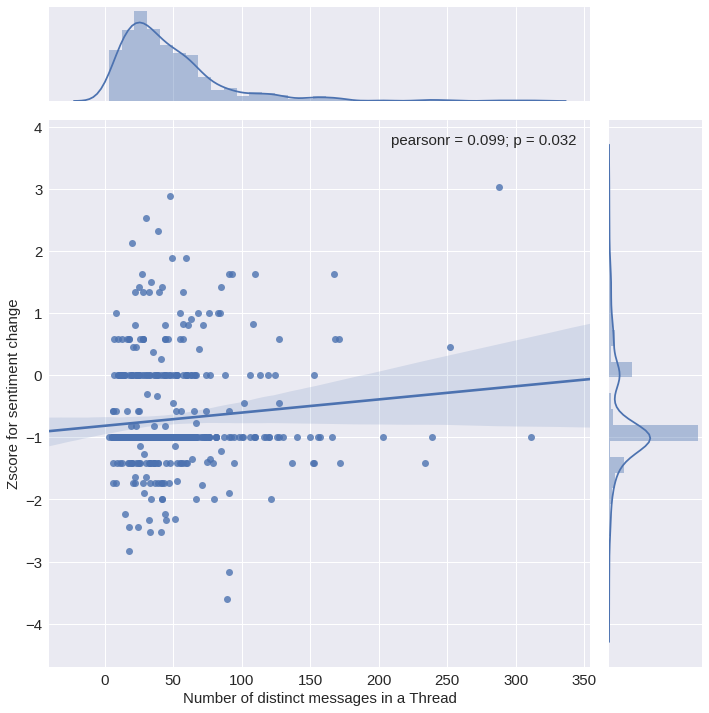

In [98]:
sns.jointplot(x = np.asarray(conversations) , y = np.asarray(Zscore) , kind='reg' ,size = 10);
plt.xlabel("Number of distinct messages in a Thread", fontsize = 15)
plt.ylabel("Zscore for sentiment change", fontsize = 15)

In [99]:
len(list(set(rootAuthors)))

2318

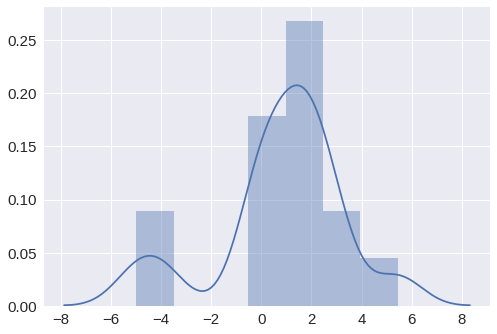

In [100]:
sns.distplot(rootSentiments)


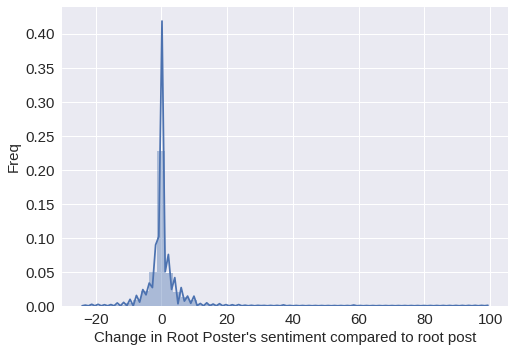

In [101]:
sns.distplot(sentiChanges,kde=True)
plt.xlabel("Change in Root Poster's sentiment compared to root post", fontsize = 15)
plt.ylabel("Freq", fontsize = 15)

In [102]:
float(len([k for k in sentiChanges if k > 0]) )/  float(len(sentiChanges))

0.3503230437903805

In [103]:
sigma = np.std(sentiChanges)
mean = np.mean(sentiChanges)


In [104]:
Zscore = [(float(k) - mean)/sigma for k in sentiChanges]

In [105]:
len(medianRootSentiments)

472

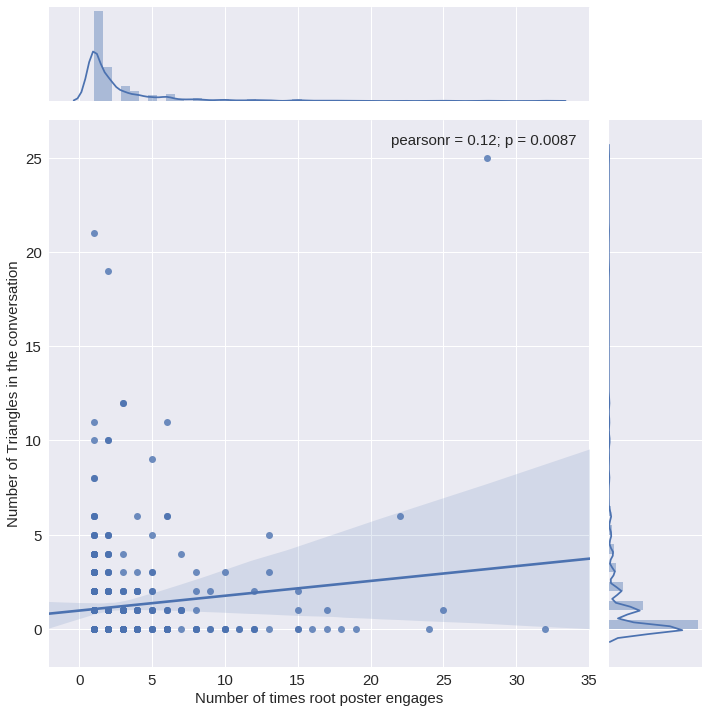

In [106]:
sns.jointplot(x = np.asarray(rootEngagement) , y = np.asarray(triangles) , kind='reg' ,size = 10);
plt.ylabel("Number of Triangles in the conversation", fontsize = 15)
plt.xlabel("Number of times root poster engages", fontsize = 15)

In [107]:
import nltk
from nltk.collocations import *
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))    
exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [108]:
def clean(doc):

    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

In [109]:
textList = []
for k in allGraphs:
    postText = nx.get_node_attributes(allGraphs[k],'text')
    for t in postText:
        textList.append(postText[t])

In [110]:
textList[1]

'[deleted]'

In [111]:
# Tokenizer = TweetTokenizer()
# postCorpus = []
# for news in textList:
#     utfnews = news
#     tokens = Tokenizer.tokenize(utfnews)
#     for token in tokens:
#         postCorpus.append(token)

In [112]:
# trigram_measures = nltk.collocations.TrigramAssocMeasures()
# finder = TrigramCollocationFinder.from_words(postCorpus, window_size = 4)
# finder.apply_freq_filter(100)
# print sorted(finder.nbest(trigram_measures.pmi, 30))

In [113]:
# bigram_measures = nltk.collocations.BigramAssocMeasures()
# finder = BigramCollocationFinder.from_words(postCorpus, window_size = 3)
# finder.apply_freq_filter(200)
# print sorted(finder.nbest(bigram_measures.pmi, 30))

In [114]:
# print sorted(finder.nbest(trigram_measures.pmi, 30))

In [115]:
# print sorted(finder.nbest(bigram_measures.pmi, 30))